# Multiple Instance Learning with Graph Neural Networks
### `IABI Course, Dr. Rohban`
#### Homework 1
*`Full Name:`* Fatemeh Shahhosseini
*`SID:`* 403206519

## Proposed Method Description

In this notebook, we explore **Multiple Instance Learning (MIL)** by leveraging **Graph Neural Networks (GNNs)** to learn bag-level representations. We will treat each bag of instances as a graph, where the individual instances are treated as nodes, and the edges between them capture their relationships. The goal is to explore the structural information within the bags and use GNNs to learn meaningful embeddings that can be used for **bag-level classification**.

We will use the MNIST Bags dataset, where each bag consists of multiple images (instances) of digits, and the bag-level label corresponds to whether the bag consists of 9 or not.

### Imports

In [6]:
! pip install torch_geometric chamferdist

  Preparing metadata (setup.py) ... done
  Created wheel for chamferdist: filename=chamferdist-1.0.3-cp310-cp310-linux_x86_64.whl size=6458844 sha256=8c61bf60294ab5c2cbbcaaaefac1734c28ee5015f8940b3479aebafdd66ac502
  Stored in directory: /root/.cache/pip/wheels/e4/18/72/8195757e9529dc3e3d0b63c729c3fa5b6b753f47106e675741
Successfully built chamferdist


In [7]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, ClusterGCNConv, global_max_pool, max_pool, dense_diff_pool, DenseSAGEConv
from torch_geometric.data import NeighborSampler, Data
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_ut
from chamferdist import ChamferDistance
import numpy as np
from torchvision import datasets, transforms

### Dataset
Create a dataset object that contains bags and their labels.

In [75]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

class MNIST_Bags(torch.utils.data.Dataset):
    """
    Custom dataset class for creating bags of MNIST images, used for tasks like multi-instance learning.
    """
    def __init__(self, target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=250, seed=1, train=True):
        """
        Initializes the dataset with the given parameters and random seed.
        """
        self.target_number = target_number
        self.mean_bag_length = mean_bag_length
        self.var_bag_length = var_bag_length
        self.num_bag = num_bag
        self.train = train
        self.r = np.random.RandomState(seed)
        self.num_in_train = 60000  # MNIST training dataset size
        self.num_in_test = 10000   # MNIST test dataset size

    def prepare_data(self,bags):
        data_list = []
        for images, label in bags:
            graph = create_graph_from_bag(images, label)
            data_list.append(graph)
        return data_list


    # Create MNIST Bags dataset
    def create_mnist_bags(self,dataset, bag_size=10, target_digit=9):
        """
        Create bags of MNIST images for Multiple Instance Learning.
        Each bag has a label of 1 if it contains at least one `target_digit`, otherwise 0.
        """
        bags = []
        for _ in range(len(dataset) // bag_size):
            indices = torch.randperm(len(dataset))[:bag_size]
            images, labels = zip(*[dataset[i] for i in indices])
            images = torch.stack([img.squeeze() for img in images])
            labels = torch.tensor(labels)

            bag_label = 1 if (labels == target_digit).any() else 0
            bags.append((images, bag_label))

        dataset = prepare_data(bags)
        return dataset

    def create_graph_from_bag(self,images, label, threshold=0.5):
        """
        Convert a bag of MNIST images into a graph representation.
        Nodes: Individual images (instances) in the bag.
        Edges: Similarity-based relationships between images.
        """
        num_images = images.shape[0]
        x = images.view(num_images, -1)  # Flatten each image into a feature vector

        # Compute edges based on cosine similarity
        edge_index = []
        for i in range(num_images):
            for j in range(i + 1, num_images):
                similarity = F.cosine_similarity(x[i].unsqueeze(0), x[j].unsqueeze(0)).item()
                if similarity > threshold:
                    edge_index.append([i, j])
                    edge_index.append([j, i])

        x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize node features
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        y = torch.tensor([label], dtype=torch.long)

        return Data(x=x, edge_index=edge_index, y=y)



#### Visualize the data

Visulaize two bags of our dataset to get more familiar with it.

In [60]:
# TODO: Visualize two bags of the dataset with their labels.
# You should:
# 1. Extract two bags and their corresponding labels.
# 2. Visualize the images in each bag using matplotlib.
# 3. Make sure to include the label in the title of each plot.

dataset = MNIST_Bags()

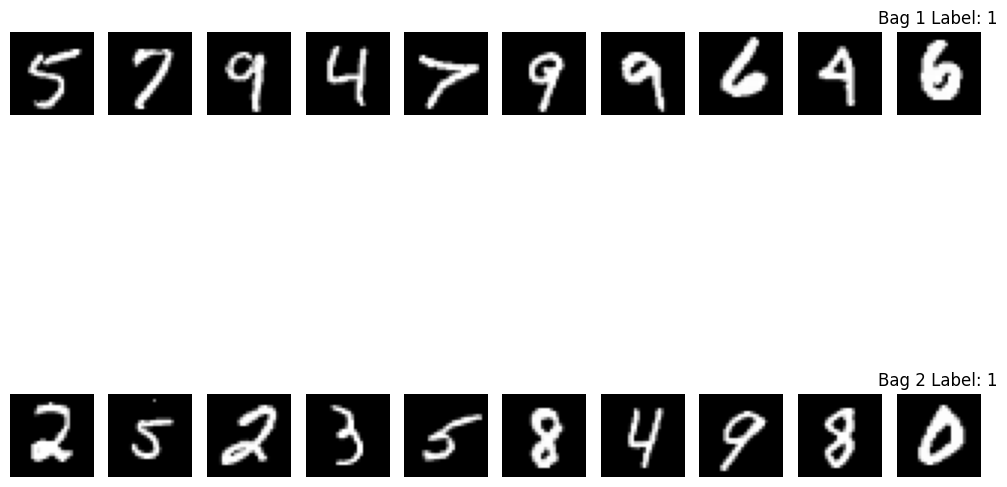

In [68]:

num_bags = 2
plt.figure(figsize=(10, num_bags * 5))

for bag_idx in range(num_bags):
    # Extract the bag and its label
    bag, label = test_bags[bag_idx]
    bag_label = label  # Overall bag label (presence of target digit)

    # Create a subplot for each bag
    num_instances = bag.size(0)
    for img_idx in range(num_instances):
        plt.subplot(num_bags, num_instances, bag_idx * num_instances + img_idx + 1)
        plt.imshow(bag[img_idx].squeeze().numpy(), cmap='gray')
        plt.axis('off')

    # Add the bag label as a title for the entire row
    plt.title(
        f"Bag {bag_idx + 1} Label: {bag_label}"
    )

plt.tight_layout()
plt.show()


#### Data Loaders
Use DataLoader to get the train and test loaders. Do not change the manual seed that has been set!

In [59]:
# TODO: Load the MNIST_Bags dataset using the DataLoader for both training and testing.
# - Do not delete the torch.manual_seed(1)!
# - Use the following parameters for the training and test sets:
target_number = 9
mean_bag_length = 10
var_bag_length = 2
number_train_items = 300
number_test_items = 100

from torch.utils.data import DataLoader
# Set random seed for reproducibility
torch.manual_seed(1)
dataset = MNIST_Bags()

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create MNIST Bags dataset
train_data_list = dataset.create_mnist_bags(mnist_train, bag_size=10, target_digit=9)
test_data_list = dataset.create_mnist_bags(mnist_test, bag_size=10, target_digit=9)

train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)


### Model

Here we will define our GraphBasedMIL model, complete each funcion based on the comments. An overview of the architecture is here:

<img src="./milgnn_arch.jpg" width="300" style="display:inline-block" />
<img src="./overview_mil_gnn.png" width="300" style="display:inline-block" />


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphBasedMIL(nn.Module):

    def __init__(self,input_dim, hidden_dim, output_dim):

        super(GraphBasedMIL, self).__init__()

        # Define internal model parameters
        self.L = 50  # Dimensionality of node features
        self.C = 1   # Number of clusters
        self.classes = 2  # Number of classes for classification

        self.n = 50  # Threshold for graph edge distance (0 = no edge, inf = fully connected)
        self.n_step = 0.5  # Step increment for the edge distance if not enough edges are created
        self.num_adj_parm = 0.1  # Minimum graph adjacency length to avoid sparse graphs

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU(),
        )

        # Define GNN layers and other parameters
        self.gnn_embd = nn.Sequential(
            nn.Linear(self.L, self.L),
            nn.ReLU(),
            nn.BatchNorm1d(self.L)
        )

        self.gnn_pool = nn.Sequential(
            nn.Linear(self.L, self.C),
            nn.ReLU(),
            nn.BatchNorm1d(self.C)
        )

        self.mlp = nn.Sequential(
            nn.Linear(self.C, self.C // 2),
            nn.ReLU(),
            nn.Linear(self.C // 2, self.classes)
        )

        self.gnn_embd2 = nn.Sequential(
            nn.Linear(self.C, self.L),
            nn.ReLU(),
            nn.BatchNorm1d(self.L)
        )

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


    def convert_bag_to_graph_(self, bag, N):

        edge_index = []
        for cur_i, cur_node in enumerate(bag):
            for alt_i, alt_node in enumerate(bag):
                if cur_i != alt_i and self.euclidean_distance_(cur_node, alt_node) < N:
                    edge_index.append(torch.tensor([cur_i, alt_i]).cuda())  # Add edge if distance is small

        if len(edge_index) < self.num_adj_parm * bag.shape[0]:
            return self.convert_bag_to_graph_(bag, N=(N + self.n_step))

        return bag, torch.stack(edge_index).transpose(1, 0)

    def euclidean_distance_(self, X, Y):

        dist = torch.sqrt(torch.sum((X - Y) ** 2))
        return dist

    def auxiliary_loss(self, A, S):

        link_loss = torch.sum(A * (S - S.mean(dim=0, keepdim=True)) ** 2)
        return link_loss

    def calculate_classification_error(self, output, target, TP, TN, FP, FN):

        predicted = torch.argmax(output, dim=1)
        TP.append((predicted == 1) & (target == 1).sum().item())
        TN.append((predicted == 0) & (target == 0).sum().item())
        FP.append((predicted == 1) & (target == 0).sum().item())
        FN.append((predicted == 0) & (target == 1).sum().item())

    def cross_entropy_loss(self, output, target):

        if len(output.shape) == 1:
            output = output.unsqueeze(0)  # Ensure output is a 2D tensor
        target = target.long().to(output.device)  # Ensure target is long and on the same device
        criterion = nn.CrossEntropyLoss()
        l1 = criterion(output, target)
        return l1

    def calculate_objective(self, X, target):

        Y_prob, aux_loss = self.forward(X)
        Y_prob = torch.clamp(Y_prob, 1e-9, 1.0)  # Clamp to prevent log(0)
        l1 = -torch.sum(target * torch.log(Y_prob))  # Negative log likelihood
        return l1 + aux_loss




### Training
Train your model for 100 epochs.

In [70]:

def train():
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        # output, _ = model(data.x)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    return total_loss / len(train_loader), acc, prec, rec

def evaluate():
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.batch)
            # output, _ = model(data.x)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    return total_loss / len(test_loader), acc, prec, rec



In [71]:
# Initialize GraphBasedMIL
input_dim = 28 * 28
hidden_dim = 64
output_dim = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphBasedMIL(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


In [40]:
from tqdm import tqdm

# Train and evaluate the model
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []

for epoch in tqdm(range(20)):
    train_loss, train_acc, train_prec, train_rec = train()
    test_loss, test_acc, test_prec, test_rec = evaluate()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_precisions.append(train_prec)
    test_precisions.append(test_prec)
    train_recalls.append(train_rec)
    test_recalls.append(test_rec)

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")


  5%|▌         | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0:
  Train Loss: 0.6179, Accuracy: 0.6615, Precision: 0.6721, Recall: 0.9229
  Test Loss: 0.5646, Accuracy: 0.7020, Precision: 0.7248, Recall: 0.8627


 10%|█         | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1:
  Train Loss: 0.5752, Accuracy: 0.6947, Precision: 0.7249, Recall: 0.8450
  Test Loss: 0.5499, Accuracy: 0.7090, Precision: 0.7596, Recall: 0.7988


 15%|█▌        | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2:
  Train Loss: 0.5461, Accuracy: 0.7152, Precision: 0.7513, Recall: 0.8315
  Test Loss: 0.5360, Accuracy: 0.7300, Precision: 0.7708, Recall: 0.8237


 20%|██        | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3:
  Train Loss: 0.5487, Accuracy: 0.7165, Precision: 0.7496, Recall: 0.8385
  Test Loss: 0.5359, Accuracy: 0.7260, Precision: 0.7751, Recall: 0.8066


 25%|██▌       | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4:
  Train Loss: 0.5362, Accuracy: 0.7232, Precision: 0.7567, Recall: 0.8383
  Test Loss: 0.5630, Accuracy: 0.6900, Precision: 0.8214, Recall: 0.6599


 30%|███       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5:
  Train Loss: 0.5337, Accuracy: 0.7293, Precision: 0.7598, Recall: 0.8458
  Test Loss: 0.5313, Accuracy: 0.7370, Precision: 0.7429, Recall: 0.9017


 35%|███▌      | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6:
  Train Loss: 0.5362, Accuracy: 0.7243, Precision: 0.7550, Recall: 0.8448
  Test Loss: 0.5294, Accuracy: 0.7340, Precision: 0.7551, Recall: 0.8658


 40%|████      | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7:
  Train Loss: 0.5369, Accuracy: 0.7308, Precision: 0.7589, Recall: 0.8512
  Test Loss: 0.5455, Accuracy: 0.7250, Precision: 0.7194, Recall: 0.9360


 45%|████▌     | 9/20 [00:11<00:14,  1.32s/it]

Epoch 8:
  Train Loss: 0.5245, Accuracy: 0.7368, Precision: 0.7658, Recall: 0.8499
  Test Loss: 0.5510, Accuracy: 0.7020, Precision: 0.8170, Recall: 0.6895


 50%|█████     | 10/20 [00:12<00:13,  1.38s/it]

Epoch 9:
  Train Loss: 0.5316, Accuracy: 0.7248, Precision: 0.7585, Recall: 0.8383
  Test Loss: 0.5289, Accuracy: 0.7360, Precision: 0.7471, Recall: 0.8892


 55%|█████▌    | 11/20 [00:13<00:11,  1.33s/it]

Epoch 10:
  Train Loss: 0.5215, Accuracy: 0.7348, Precision: 0.7676, Recall: 0.8419
  Test Loss: 0.5549, Accuracy: 0.7330, Precision: 0.7314, Recall: 0.9220


 60%|██████    | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11:
  Train Loss: 0.5256, Accuracy: 0.7290, Precision: 0.7592, Recall: 0.8463
  Test Loss: 0.5403, Accuracy: 0.7380, Precision: 0.7331, Recall: 0.9298


 65%|██████▌   | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12:
  Train Loss: 0.5301, Accuracy: 0.7275, Precision: 0.7563, Recall: 0.8492
  Test Loss: 0.5278, Accuracy: 0.7440, Precision: 0.7497, Recall: 0.9017


 70%|███████   | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13:
  Train Loss: 0.5310, Accuracy: 0.7282, Precision: 0.7557, Recall: 0.8520
  Test Loss: 0.5285, Accuracy: 0.7440, Precision: 0.7754, Recall: 0.8456


 75%|███████▌  | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14:
  Train Loss: 0.5156, Accuracy: 0.7422, Precision: 0.7682, Recall: 0.8570
  Test Loss: 0.5296, Accuracy: 0.7430, Precision: 0.7595, Recall: 0.8768


 80%|████████  | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15:
  Train Loss: 0.5211, Accuracy: 0.7335, Precision: 0.7646, Recall: 0.8450
  Test Loss: 0.6015, Accuracy: 0.6580, Precision: 0.8568, Recall: 0.5601


 85%|████████▌ | 17/20 [00:21<00:03,  1.21s/it]

Epoch 16:
  Train Loss: 0.5169, Accuracy: 0.7437, Precision: 0.7727, Recall: 0.8510
  Test Loss: 0.5350, Accuracy: 0.7150, Precision: 0.7947, Recall: 0.7488


 90%|█████████ | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17:
  Train Loss: 0.5205, Accuracy: 0.7408, Precision: 0.7703, Recall: 0.8497
  Test Loss: 0.5367, Accuracy: 0.7400, Precision: 0.7408, Recall: 0.9142


 95%|█████████▌| 19/20 [00:23<00:01,  1.32s/it]

Epoch 18:
  Train Loss: 0.5288, Accuracy: 0.7340, Precision: 0.7655, Recall: 0.8442
  Test Loss: 0.5248, Accuracy: 0.7400, Precision: 0.7710, Recall: 0.8456


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

Epoch 19:
  Train Loss: 0.5204, Accuracy: 0.7425, Precision: 0.7734, Recall: 0.8471
  Test Loss: 0.5205, Accuracy: 0.7420, Precision: 0.7747, Recall: 0.8424


### Results
Plot the F1, Precision, Recall of both train and test sets over the 100 epochs.

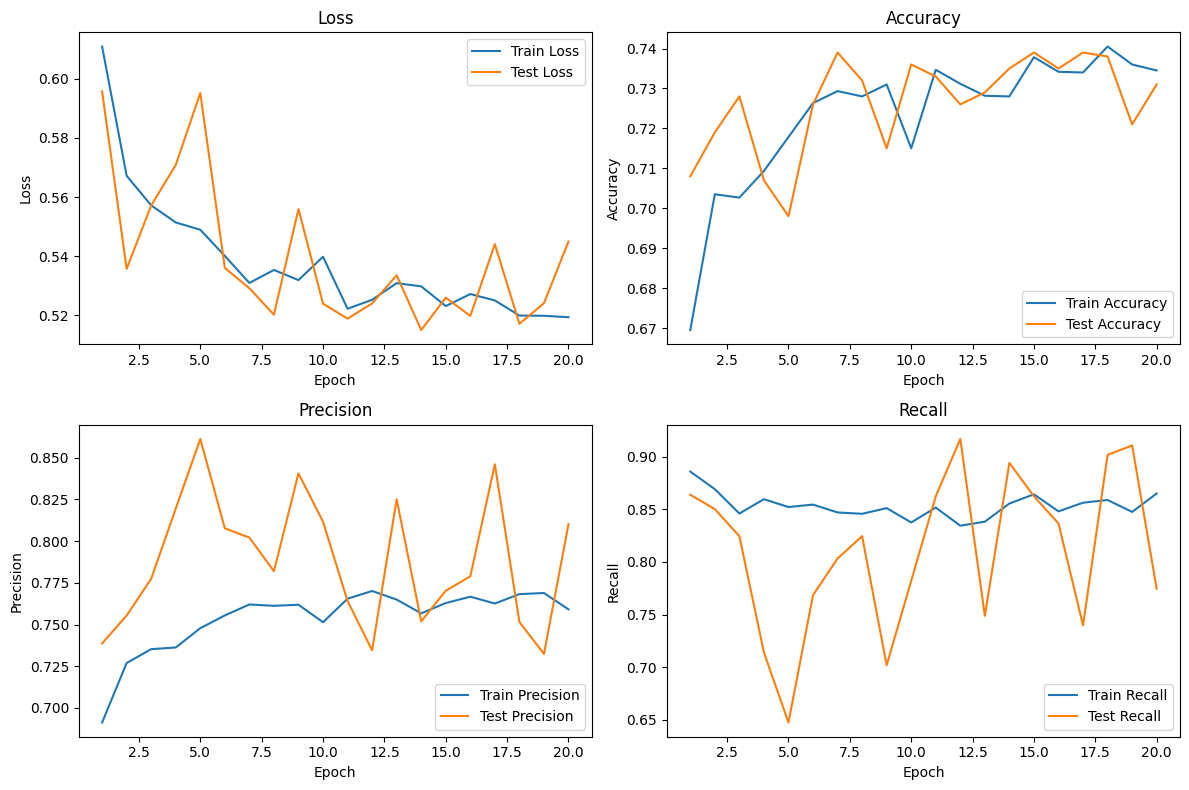

In [5]:

# Plot metrics
epochs = range(1, 21)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()


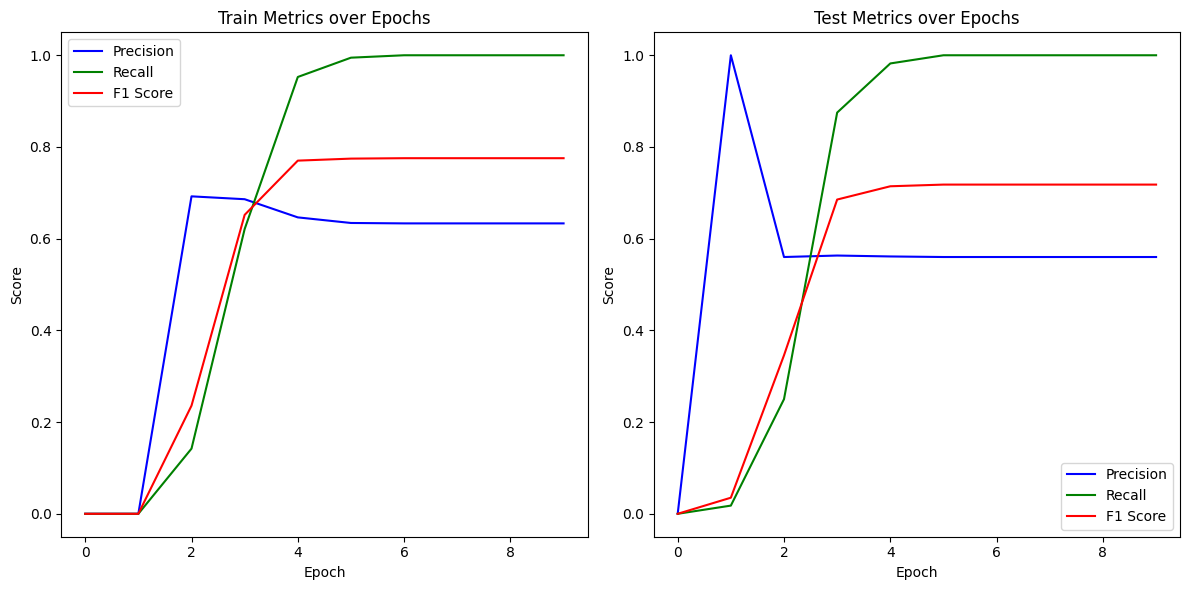

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Precision, Recall, F1 for Train
# You need to plot the Precision, Recall, and F1 score for the training set
plt.subplot(1, 2, 1)

# Plot the test metrics
# Plot the Precision, Recall, and F1 score for the test set
plt.subplot(1, 2, 2)


# Display the plots

# simple sample

In [35]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv, global_mean_pool,global_max_pool
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Create MNIST Bags dataset
def create_mnist_bags(dataset, bag_size=10, target_digit=9):
    """
    Create bags of MNIST images for Multiple Instance Learning.
    Each bag has a label of 1 if it contains at least one `target_digit`, otherwise 0.
    """
    bags = []
    for _ in range(len(dataset) // bag_size):
        indices = torch.randperm(len(dataset))[:bag_size]
        images, labels = zip(*[dataset[i] for i in indices])
        images = torch.stack([img.squeeze() for img in images])
        labels = torch.tensor(labels)

        bag_label = 1 if (labels == target_digit).any() else 0
        bags.append((images, bag_label))
    return bags

def create_graph_from_bag(images, label, threshold=0.5):
    """
    Convert a bag of MNIST images into a graph representation.
    Nodes: Individual images (instances) in the bag.
    Edges: Similarity-based relationships between images.
    """
    num_images = images.shape[0]
    x = images.view(num_images, -1)  # Flatten each image into a feature vector

    # Compute edges based on cosine similarity
    edge_index = []
    for i in range(num_images):
        for j in range(i + 1, num_images):
            similarity = F.cosine_similarity(x[i].unsqueeze(0), x[j].unsqueeze(0)).item()
            if similarity > threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])

    x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize node features
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


In [37]:

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create MNIST Bags dataset
train_bags = create_mnist_bags(mnist_train, bag_size=10, target_digit=9)
test_bags = create_mnist_bags(mnist_test, bag_size=10, target_digit=9)

def prepare_data(bags):
    data_list = []
    for images, label in bags:
        graph = create_graph_from_bag(images, label)
        data_list.append(graph)
    return data_list

train_data_list = prepare_data(train_bags)
test_data_list = prepare_data(test_bags)

train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [42]:

# Initialize GNN
input_dim = 28 * 28
hidden_dim = 64
output_dim = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(input_dim, hidden_dim, output_dim).to(device)
# model = GraphBasedMIL().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [43]:

def train():
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        # output, _ = model(data.x)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    return total_loss / len(train_loader), acc, prec, rec

def evaluate():
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.batch)
            # output, _ = model(data.x)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    return total_loss / len(test_loader), acc, prec, rec



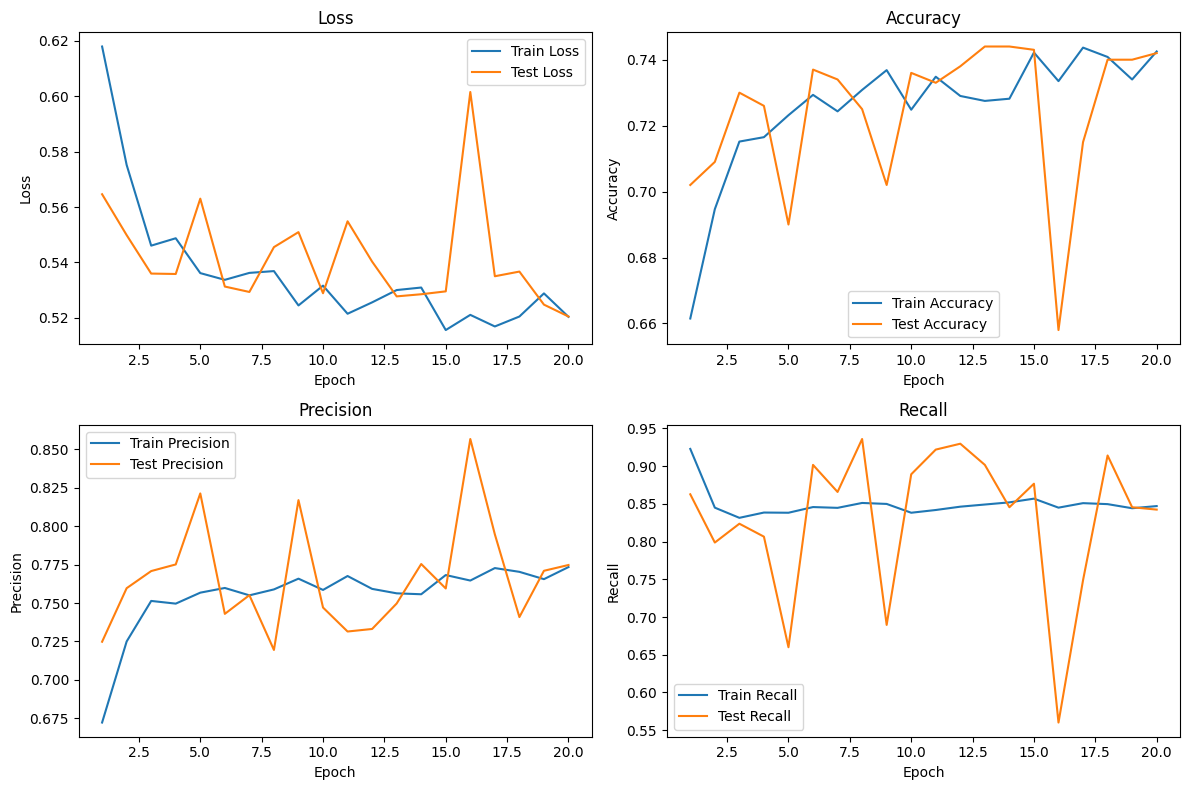

In [41]:

# Plot metrics
epochs = range(1, 21)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()


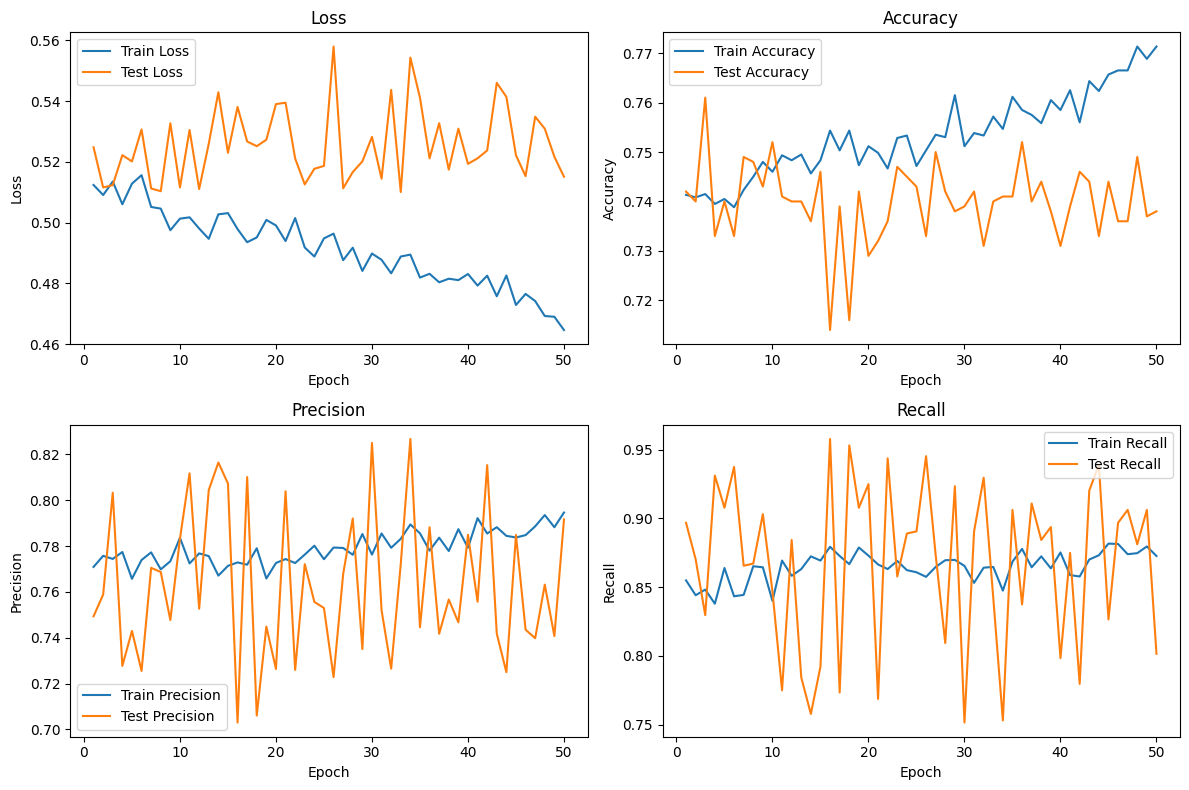

In [10]:

# Plot metrics
epochs = range(1, 51)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()
